In [2]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import itertools
import json

plt.rcParams["figure.figsize"] = (15,7)

# Reloading images

In [3]:
%%time
image = imread('/mnt/DATA/sandbox/lung_on_chip/20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_57.vsi - 001 CF405, CF488, CF561, CF638.tif')
zo1 = image[...,3]
dapi = image[...,0]
pdpn = image[...,2]
spc = image[...,1]
### labels for apical baslal wrong way round!!!!!!!!!!!!!!!!!!!!!!!!!!! nOT ANY MORE
apical_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_apical_masks.tif')
basal_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_basal_masks.tif')

CPU times: user 1.08 s, sys: 1.57 s, total: 2.65 s
Wall time: 2.64 s


In [4]:
image.shape

(81, 2304, 2304, 4)

### Defining properties to measure similarities of z-slices

In [21]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         'mean_intensity', 
         #'intensity_image', 
         'orientation')

In [54]:
%%time
apical_pdpn_objects = btrack.utils.segmentation_to_objects(
    apical_mask_stack, 
    pdpn,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
apical_pdpn_objects = [obj for obj in apical_pdpn_objects if obj.properties['area'] > 50]

[INFO][2022/08/15 05:10:09 pm] Localizing objects from segmentation...
[INFO][2022/08/15 05:10:09 pm] Found intensity_image data
[INFO][2022/08/15 05:10:09 pm] Calculating weighted centroids using intensity_image
[INFO][2022/08/15 05:10:30 pm] Objects are of type: <class 'dict'>
[INFO][2022/08/15 05:10:31 pm] ...Found 42052 objects in 81 frames.


CPU times: user 20.6 s, sys: 1.71 s, total: 22.3 s
Wall time: 22.3 s


In [58]:
%%time
basal_pdpn_objects = btrack.utils.segmentation_to_objects(
    basal_mask_stack, 
    pdpn,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
basal_pdpn_objects = [obj for obj in basal_pdpn_objects if obj.properties['area'] > 50]

[INFO][2022/08/15 05:10:31 pm] Localizing objects from segmentation...
[INFO][2022/08/15 05:10:31 pm] Found intensity_image data
[INFO][2022/08/15 05:10:31 pm] Calculating weighted centroids using intensity_image
[INFO][2022/08/15 05:10:39 pm] Objects are of type: <class 'dict'>
[INFO][2022/08/15 05:10:39 pm] ...Found 913 objects in 79 frames.


CPU times: user 1min 43s, sys: 3.66 s, total: 1min 46s
Wall time: 7.07 s


In [59]:
%%time
apical_spc_objects = btrack.utils.segmentation_to_objects(
    apical_mask_stack, 
    spc,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
apical_spc_objects = [obj for obj in apical_spc_objects if obj.properties['area'] > 50]

[INFO][2022/08/15 05:10:39 pm] Localizing objects from segmentation...
[INFO][2022/08/15 05:10:39 pm] Found intensity_image data
[INFO][2022/08/15 05:10:39 pm] Calculating weighted centroids using intensity_image
[INFO][2022/08/15 05:10:59 pm] Objects are of type: <class 'dict'>
[INFO][2022/08/15 05:11:00 pm] ...Found 42052 objects in 81 frames.


CPU times: user 22.2 s, sys: 1.71 s, total: 23.9 s
Wall time: 21 s


In [60]:
%%time
basal_spc_objects = btrack.utils.segmentation_to_objects(
    basal_mask_stack, 
    spc,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
basal_spc_objects = [obj for obj in basal_spc_objects if obj.properties['area'] > 50]

[INFO][2022/08/15 05:11:00 pm] Localizing objects from segmentation...
[INFO][2022/08/15 05:11:00 pm] Found intensity_image data
[INFO][2022/08/15 05:11:00 pm] Calculating weighted centroids using intensity_image
[INFO][2022/08/15 05:11:06 pm] Objects are of type: <class 'dict'>
[INFO][2022/08/15 05:11:06 pm] ...Found 913 objects in 79 frames.


CPU times: user 1min 38s, sys: 3.15 s, total: 1min 41s
Wall time: 6.37 s


## Attempting some tracking

In [61]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')

  # append the objects to be tracked
  tracker.append(basal_spc_objects)

  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))

  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)

  # generate hypotheses and run the global optimizer
  tracker.optimize()

  # get the tracks as a python list
  tracks = tracker.tracks

  # optional: get the data in a format for napari
  data, properties, graph = tracker.to_napari()

[INFO][2022/08/15 05:11:18 pm] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/08/15 05:11:18 pm] btrack (v0.4.5) library imported
[INFO][2022/08/15 05:11:18 pm] Starting BayesianTracker session
[INFO][2022/08/15 05:11:18 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/08/15 05:11:18 pm] Objects are of type: <class 'list'>
[INFO][2022/08/15 05:11:18 pm] Starting tracking... 
[INFO][2022/08/15 05:11:18 pm] Tracking objects in frames 0 to 79 (of 79)...
[INFO][2022/08/15 05:11:18 pm]  - Timing (Bayesian updates: 0.01ms, Linking: 0.02ms)
[INFO][2022/08/15 05:11:18 pm]  - Probabilities (Link: 0.99226, Lost: 1.00000)
[INFO][2022/08/15 05:11:18 pm] SUCCESS.
[INFO][2022/08/15 05:11:18 pm]  - Found 356 tracks in 79 frames (in 0.0s)
[INFO][2022/08/15 05:11:18 pm]  - Inserted 135 dummy objects to fill tracking gaps
[INFO][2022/08/15 05:11:18 pm] Loading hypothesis model: pa

GLPK Integer Optimizer 5.0
1424 rows, 1151 columns, 1590 non-zeros
1151 integer variables, all of which are binary
Preprocessing...
712 rows, 1151 columns, 1590 non-zeros
1151 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 712
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
712 rows, 1151 columns, 1590 non-zeros
*     0: obj =   4.674935875e+03 inf =   0.000e+00 (415)
*   442: obj =   1.736561746e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   442: mip =     not found yet >=              -inf        (1; 0)
+   442: >>>>>   1.736561746e+03 >=   1.736561746e+03   0.0% (1; 0)
+   442: mip =   1.736561746e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


### Filtering segments based on whether they are tracked over z

In [62]:
len(tracks)

347

In [63]:
filtered_tracks = [track for track in tracks if len(track) >= 3]

In [64]:
len(filtered_tracks)

111

In [65]:
visualise_tracks, properties, graph = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)

In [66]:
viewer = napari.Viewer()
viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'yellow', blending = 'additive')
viewer.add_image(spc, colormap='green', blending = 'additive')
viewer.add_image(pdpn, colormap= 'red', blending = 'additive')

viewer.add_labels(basal_mask_stack)
viewer.add_labels(apical_mask_stack)

viewer.add_tracks(visualise_tracks, properties = properties, graph = graph)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'visualise_tracks' at 0x7fdb6752e430>

In [67]:
[(len(track), track.ID) for track in filtered_tracks]

[(10, 2),
 (5, 13),
 (8, 36),
 (3, 38),
 (3, 39),
 (5, 46),
 (5, 49),
 (5, 48),
 (9, 40),
 (7, 43),
 (8, 41),
 (4, 60),
 (7, 66),
 (5, 64),
 (6, 63),
 (3, 56),
 (7, 55),
 (4, 54),
 (6, 53),
 (4, 52),
 (7, 70),
 (5, 80),
 (5, 73),
 (5, 71),
 (6, 69),
 (3, 98),
 (8, 100),
 (4, 101),
 (6, 102),
 (3, 103),
 (3, 104),
 (3, 106),
 (3, 108),
 (5, 93),
 (4, 95),
 (4, 82),
 (3, 83),
 (3, 85),
 (4, 92),
 (3, 149),
 (3, 148),
 (3, 144),
 (3, 143),
 (6, 142),
 (4, 139),
 (5, 138),
 (5, 140),
 (3, 150),
 (3, 151),
 (3, 152),
 (6, 154),
 (4, 156),
 (4, 157),
 (7, 158),
 (7, 159),
 (5, 111),
 (3, 112),
 (4, 114),
 (4, 119),
 (3, 124),
 (7, 136),
 (6, 134),
 (4, 133),
 (7, 132),
 (3, 131),
 (4, 129),
 (5, 127),
 (6, 188),
 (3, 190),
 (3, 175),
 (4, 196),
 (4, 203),
 (3, 182),
 (3, 163),
 (5, 171),
 (5, 181),
 (6, 179),
 (3, 177),
 (4, 174),
 (4, 224),
 (5, 233),
 (3, 238),
 (3, 239),
 (3, 220),
 (5, 210),
 (9, 211),
 (4, 213),
 (5, 218),
 (3, 212),
 (3, 222),
 (3, 255),
 (4, 257),
 (4, 258),
 (4, 259)

In [74]:
track_36 = [track for track in tracks if track.ID == 36][0]

In [75]:
track_36

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,mean_intensity,axis_major_length,eccentricity,area,axis_minor_length
0,36,43,716.713154,1928.787515,0.0,36,36,5,0,False,1.487303,228.570035,215.587985,0.808102,21018,126.990457
1,36,44,725.294518,1931.874733,0.0,36,36,5,0,False,1.391868,226.847113,260.690045,0.886423,23900,120.667187
2,36,45,724.224490,1932.026898,0.0,36,36,5,0,False,1.361748,225.379558,263.779376,0.863366,27395,133.097322
3,36,46,722.457141,1933.183871,0.0,36,36,5,0,False,1.403524,217.584922,268.677221,0.869154,27749,132.872079
4,36,47,722.728260,1934.418905,0.0,36,36,5,0,False,1.396564,192.658155,267.581998,0.861597,28197,135.822753
5,36,48,722.534413,1931.285715,0.0,36,36,5,0,False,1.392110,164.840165,267.258862,0.849517,29080,140.995308
6,36,49,718.743181,1934.382537,0.0,36,36,5,0,False,1.351366,144.058666,259.961223,0.840046,28330,141.032988
7,36,50,719.331833,1930.778021,0.0,36,36,5,0,False,1.376158,131.616820,263.257375,0.841748,28407,142.125022


#### Pytrackobjects do not support item assignment, so I cannot append the mean intensity channel information from one reading to another

Need a better way to identify same tracks and compare mean intensities across channels

##### Tracking other channel objs

In [138]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(basal_pdpn_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  basal_pdpn_tracks = tracker.tracks
  # filter tracks
  basal_pdpn_tracks = [track for track in basal_pdpn_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  basal_pdpn_data, properties, graph = tracker.to_napari()
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(basal_spc_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  basal_spc_tracks = tracker.tracks
  # filter tracks
  basal_spc_tracks = [track for track in basal_spc_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  basal_spc_data, properties, graph = tracker.to_napari()

[INFO][2022/08/16 11:11:54 am] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/08/16 11:11:54 am] btrack (v0.4.5) library imported
[INFO][2022/08/16 11:11:54 am] Starting BayesianTracker session
[INFO][2022/08/16 11:11:54 am] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/08/16 11:11:54 am] Objects are of type: <class 'list'>
[INFO][2022/08/16 11:11:54 am] Starting tracking... 
[INFO][2022/08/16 11:11:54 am] Tracking objects in frames 0 to 79 (of 79)...
[INFO][2022/08/16 11:11:54 am]  - Timing (Bayesian updates: 0.01ms, Linking: 0.03ms)
[INFO][2022/08/16 11:11:54 am]  - Probabilities (Link: 0.99301, Lost: 1.00000)
[INFO][2022/08/16 11:11:54 am] SUCCESS.
[INFO][2022/08/16 11:11:54 am]  - Found 350 tracks in 79 frames (in 0.0s)
[INFO][2022/08/16 11:11:54 am]  - Inserted 119 dummy objects to fill tracking gaps
[INFO][2022/08/16 11:11:54 am] Loading hypothesis model: pa

GLPK Integer Optimizer 5.0
1400 rows, 1126 columns, 1552 non-zeros
1126 integer variables, all of which are binary
Preprocessing...
700 rows, 1126 columns, 1552 non-zeros
1126 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 700
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
700 rows, 1126 columns, 1552 non-zeros
*     0: obj =   4.595111432e+03 inf =   0.000e+00 (401)
*   425: obj =   1.697624208e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   425: mip =     not found yet >=              -inf        (1; 0)
+   425: >>>>>   1.697624208e+03 >=   1.697624208e+03   0.0% (1; 0)
+   425: mip =   1.697624208e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
GLPK Integer Optimizer 5.0
1424 rows, 1151 columns, 1590 non-zeros
1151 i

[INFO][2022/08/16 11:11:54 am]  - Fates.FALSE_POSITIVE: 320 (of 356)
[INFO][2022/08/16 11:11:54 am]  - Fates.LINK: 9 (of 83)
[INFO][2022/08/16 11:11:54 am]  - Fates.INITIALIZE_FRONT: 1 (of 8)
[INFO][2022/08/16 11:11:54 am]  - Fates.INITIALIZE_LAZY: 26 (of 348)
[INFO][2022/08/16 11:11:54 am]  - Fates.TERMINATE_BACK: 2 (of 7)
[INFO][2022/08/16 11:11:54 am]  - Fates.TERMINATE_LAZY: 25 (of 349)
[INFO][2022/08/16 11:11:54 am]  - TOTAL: 1151 hypotheses
[INFO][2022/08/16 11:11:54 am] Completed optimization with 347 tracks
[INFO][2022/08/16 11:11:54 am] Ending BayesianTracker session


712 rows, 1151 columns, 1590 non-zeros
1151 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 712
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
712 rows, 1151 columns, 1590 non-zeros
*     0: obj =   4.674935875e+03 inf =   0.000e+00 (415)
*   442: obj =   1.736561746e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   442: mip =     not found yet >=              -inf        (1; 0)
+   442: >>>>>   1.736561746e+03 >=   1.736561746e+03   0.0% (1; 0)
+   442: mip =   1.736561746e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


In [146]:
basal_pdpn_tracks[45]

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,mean_intensity,axis_major_length,eccentricity,area,axis_minor_length
0,138,48,1230.475727,873.895220,0.0,138,138,5,0,False,0.058614,268.282885,218.829290,0.769990,22974,139.625337
1,138,49,1242.030041,871.756804,0.0,138,138,5,0,False,0.137645,249.098245,199.787931,0.641737,23024,153.222325
2,138,50,1256.341547,868.748190,0.0,138,138,5,0,False,-1.125566,214.712640,198.669029,0.342779,26994,186.632847
3,138,51,1260.869948,871.067097,0.0,138,138,5,0,False,-1.295596,184.133145,221.045664,0.526973,29006,187.862746
4,138,52,1261.908524,874.960660,0.0,138,138,5,0,False,-1.068923,162.035071,242.837431,0.655931,30966,183.298655


In [148]:
basal_spc_tracks[45]

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,mean_intensity,axis_major_length,eccentricity,area,axis_minor_length
0,138,48,1228.534772,876.890853,0.0,138,138,5,0,False,0.058614,283.607208,218.829290,0.769990,22974,139.625337
1,138,49,1241.346143,873.092358,0.0,138,138,5,0,False,0.137645,259.809807,199.787931,0.641737,23024,153.222325
2,138,50,1253.865007,869.928786,0.0,138,138,5,0,False,-1.125566,215.392754,198.669029,0.342779,26994,186.632847
3,138,51,1257.862062,872.503574,0.0,138,138,5,0,False,-1.295596,183.928532,221.045664,0.526973,29006,187.862746
4,138,52,1259.199209,876.669102,0.0,138,138,5,0,False,-1.068923,160.649616,242.837431,0.655931,30966,183.298655


#### Eliminating tracks that have dummy figures in them

In [175]:
spc_dummy_count = 0
pdpn_dummy_count = 0
spc_tracks_final, pdpn_tracks_final = [], []
for spc_track, pdpn_track in zip(basal_pdpn_tracks, basal_spc_tracks):
    if any(spc_track.dummy) == True:
        spc_dummy_count+=1
    else:
        spc_tracks_final.append(spc_track)
    if any(pdpn_track.dummy) == True:
        pdpn_dummy_count+=1
    else:    
        pdpn_tracks_final.append(pdpn_track)
#     for prop in spc_track.properties:
#         if (spc_track.properties[prop] != pdpn_track.properties[prop]).all():
#             print(spc_track.ID, prop)

In [176]:
len(basal_spc_tracks), spc_dummy_count, pdpn_dummy_count

(111, 65, 68)

In [177]:
pdpn_tracks_final[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,mean_intensity,axis_major_length,eccentricity,area,axis_minor_length
0,36,43,716.713154,1928.787515,0.0,36,36,5,0,False,1.487303,228.570035,215.587985,0.808102,21018,126.990457
1,36,44,725.294518,1931.874733,0.0,36,36,5,0,False,1.391868,226.847113,260.690045,0.886423,23900,120.667187
2,36,45,724.224490,1932.026898,0.0,36,36,5,0,False,1.361748,225.379558,263.779376,0.863366,27395,133.097322
3,36,46,722.457141,1933.183871,0.0,36,36,5,0,False,1.403524,217.584922,268.677221,0.869154,27749,132.872079
4,36,47,722.728260,1934.418905,0.0,36,36,5,0,False,1.396564,192.658155,267.581998,0.861597,28197,135.822753
5,36,48,722.534413,1931.285715,0.0,36,36,5,0,False,1.392110,164.840165,267.258862,0.849517,29080,140.995308
6,36,49,718.743181,1934.382537,0.0,36,36,5,0,False,1.351366,144.058666,259.961223,0.840046,28330,141.032988
7,36,50,719.331833,1930.778021,0.0,36,36,5,0,False,1.376158,131.616820,263.257375,0.841748,28407,142.125022


In [186]:
spc_tracks_final[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,mean_intensity,axis_major_length,eccentricity,area,axis_minor_length
0,37,43,716.641248,1928.392270,0.0,37,37,5,0,False,1.487303,208.070463,215.587985,0.808102,21018,126.990457
1,37,44,725.182403,1930.928537,0.0,37,37,5,0,False,1.391868,209.834686,260.690045,0.886423,23900,120.667187
2,37,45,724.255007,1931.085607,0.0,37,37,5,0,False,1.361748,211.870852,263.779376,0.863366,27395,133.097322
3,37,46,722.365465,1932.131880,0.0,37,37,5,0,False,1.403524,205.738873,268.677221,0.869154,27749,132.872079
4,37,47,722.644544,1933.422225,0.0,37,37,5,0,False,1.396564,183.708019,267.581998,0.861597,28197,135.822753
5,37,48,722.384566,1930.719551,0.0,37,37,5,0,False,1.392110,158.724450,267.258862,0.849517,29080,140.995308
6,37,49,718.671850,1933.808834,0.0,37,37,5,0,False,1.351366,140.558948,259.961223,0.840046,28330,141.032988
7,37,50,719.232684,1930.362636,0.0,37,37,5,0,False,1.376158,130.325061,263.257375,0.841748,28407,142.125022


In [178]:
import pandas as pd

In [180]:
mean_int_dict = pd.DataFrame(columns=['PDPN Single Cell Mean Intensity','APC Single Cell Mean Intensity'] )
for n, (pdpn_track, spc_track) in enumerate(zip(pdpn_tracks_final, spc_tracks_final)):
    single_cell_pdpn = sum(pdpn_track.properties['mean_intensity'])/len(pdpn_track)
    single_cell_spc = sum(spc_track.properties['mean_intensity'])/len(spc_track)
    mean_int_dict.loc[n] = [single_cell_pdpn, single_cell_spc]
    

In [181]:
mean_int_dict

,PDPN Single Cell Mean Intensity,APC Single Cell Mean Intensity
0,191.444429,181.103919
1,222.387363,185.389990
2,214.073860,205.199405
3,222.740960,192.542570
4,215.942090,217.532848
5,176.028152,161.659914
6,211.536396,189.336748
7,173.495999,180.325140
8,237.547635,196.479311
9,164.328439,207.873515


In [182]:
import seaborn as sns

Text(0, 0.5, 'Mean Fluorescence Intensity')

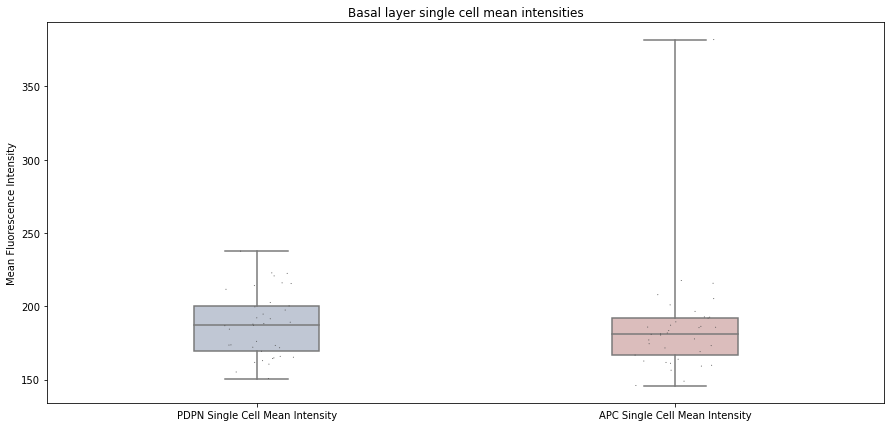

In [185]:
sns.stripplot(data=mean_int_dict,
              size=1, color=".3", linewidth=0)
# Plot the orbital period with horizontal boxes
sns.boxplot(data=mean_int_dict,
            whis=[0, 100], width=0.3, palette="vlag")
plt.title('Basal layer single cell mean intensities')
plt.ylabel('Mean Fluorescence Intensity')

### Visualise the data

In [187]:
visualise_pdpn_final_tracks, properties, graph = btrack.utils.tracks_to_napari(pdpn_tracks_final, ndim=2)
visualise_spc_final_tracks, properties, graph = btrack.utils.tracks_to_napari(spc_tracks_final, ndim=2)

In [188]:
viewer = napari.Viewer()

viewer = napari.Viewer()
viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'yellow', blending = 'additive')
viewer.add_image(spc, colormap='green', blending = 'additive')
viewer.add_image(pdpn, colormap= 'red', blending = 'additive')

viewer.add_labels(basal_mask_stack)
viewer.add_labels(apical_mask_stack)

viewer.add_tracks(visualise_pdpn_final_tracks, name = 'pdpn')
viewer.add_tracks(visualise_spc_final_tracks, name = 'spc')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'spc [1]' at 0x7fdcbb058fa0>

In [189]:
max_int_dict = pd.DataFrame(columns=['PDPN Single Cell Max Intensity','SPC Single Cell Max Intensity'] )
for n, (pdpn_track, spc_track) in enumerate(zip(pdpn_tracks_final, spc_tracks_final)):
    single_cell_pdpn = max(pdpn_track.properties['mean_intensity'])
    single_cell_spc = max(spc_track.properties['mean_intensity'])
    max_int_dict.loc[n] = [single_cell_pdpn, single_cell_spc]

Text(0, 0.5, 'Max Fluorescence Intensity')

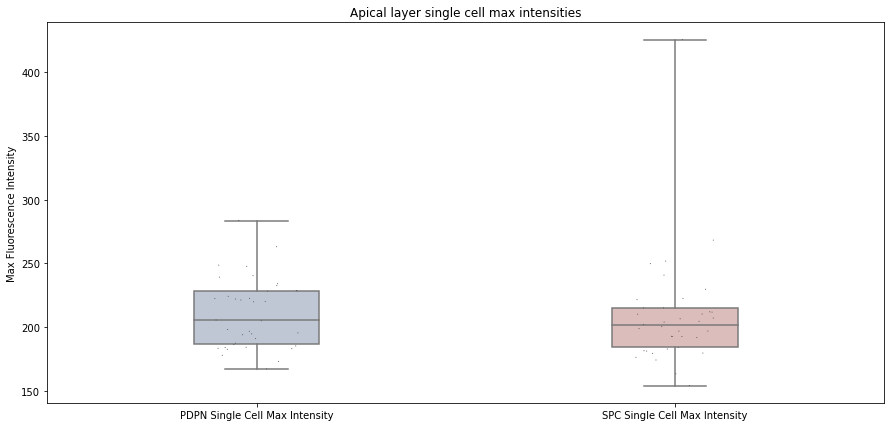

In [190]:
sns.stripplot(data=max_int_dict,
              size=1, color=".3", linewidth=0)
# Plot the orbital period with horizontal boxes
sns.boxplot(data=max_int_dict,
            whis=[0, 100], width=0.3, palette="vlag")
plt.title('Apical layer single cell max intensities')
plt.ylabel('Max Fluorescence Intensity')

Text(0, 0.5, 'Mean intensity of PDPN')

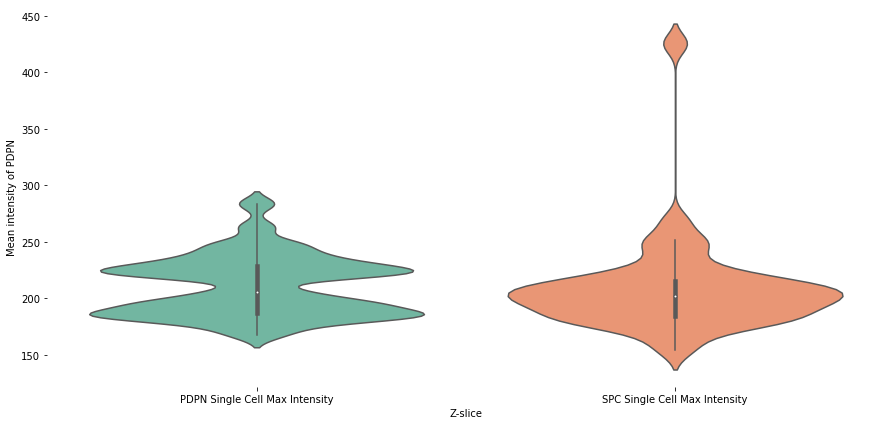

In [193]:
sns.violinplot(data=max_int_dict, palette="Set2", split=True,
                    scale="count", #inner="stick",
                    scale_hue=False, bw=.2)
sns.despine(left=True, bottom=True)
plt.xlabel('Z-slice')
plt.ylabel('Mean intensity of PDPN')

Basal side is expected to be negative for both PDPN and SPC

In [204]:
cutoff_pdpn = 200
cutoff_spc = 200

"Positive" PPDN Basal cells

In [205]:
len(max_int_dict[max_int_dict['PDPN Single Cell Max Intensity']>cutoff_pdpn])

20

"Positive" SPC Basal cells

In [206]:
len(max_int_dict[max_int_dict['SPC Single Cell Max Intensity']>cutoff_spc])

20

### Notes on performance

1. Not every cell is caught by both tracking approaches
    1. Would be better to try and measure from same object localisation
2. Think about removing background measure from images
3. Clearly define cutoff threshold based on examples
    3. From both the basal and apical layers

   